In [16]:
import os
import vtk
import numpy as np
import matplotlib.pyplot as plt
from utilities import ReadVTIFile, WriteVTPFile
import xml.etree.ElementTree as ET
from scipy.spatial.transform import Rotation as R
from vtk.util.numpy_support import vtk_to_numpy


InputFolder = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/FlowVisualization/SU03B/Paths"
g1 = os.path.join(InputFolder,"graft1.pth")
g2 = os.path.join(InputFolder,"graft2.pth")
image = os.path.join(InputFolder, "SU03B.vti")


In [17]:
ImageVTI = ReadVTIFile(image)

In [18]:
def CutPlane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

def PlaneClip(volume,center, a):
    box = vtk.vtkBox()
    box.SetBounds(
        center[0] - a, center[0] + a,
        center[1] - a, center[1] + a,
        center[2] - a, center[2] + a
    )

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(volume)
    clipper.SetClipFunction(box)
    clipper.InsideOutOn()
    clipper.GetOutputInformation(1)
    clipper.Update()

    return clipper.GetOutput()

def clip_polydata_with_plane(polydata, origin, normal, inside_out=False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipPolyData()
    clipper.SetInputData(polydata)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

In [19]:
pathline_file = g1

with open(pathline_file, "r") as path:
    #path.readlines()
    tree = ET.parse(path)
root = tree.getroot()

direction_points = []
for direction_point in root.findall(".//path_point/tangent"):
    x = float(direction_point.attrib['x'])
    y = float(direction_point.attrib['y'])
    z = float(direction_point.attrib['z'])
    direction_points.append((x,y,z))

path_points = []
for path_point in root.findall(".//path_point/pos"):
    x = float(path_point.attrib['x'])
    y = float(path_point.attrib['y'])
    z = float(path_point.attrib['z'])
    path_points.append((x,y,z))

path_normals = []
for normal in root.findall(".//path_point/rotation"):
    x = float(normal.attrib['x'])
    y = float(normal.attrib['y'])
    z = float(normal.attrib['z'])
    path_normals.append((x,y,z))

NPoints = len(path_points)
print("the number of points in the centerline is:", NPoints)

binormal = []
for i in range(NPoints):
    binormal_ = np.cross(np.array(direction_points[i]),np.array(path_normals[i]))
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)

the number of points in the centerline is: 113


In [59]:
p = path_points[2]
p_ = path_points[0]
a_ = (((p[0]-p_[0])**2 + (p[1]-p_[1])**2 + (p[2]-p_[2])**2)**0.5)/2

print(a_)

0.021932591874988822


In [ ]:
New_Centreline = np.array([-i*a_*2 for i in range(0,int((NPoints-1)/4))])
New_Centreline

array([ 0.        , -0.0109663 , -0.02193259, -0.03289889, -0.04386518,
       -0.05483148, -0.06579778, -0.07676407, -0.08773037, -0.09869666,
       -0.10966296, -0.12062926, -0.13159555, -0.14256185, -0.15352814,
       -0.16449444, -0.17546073, -0.18642703, -0.19739333, -0.20835962,
       -0.21932592, -0.23029221, -0.24125851, -0.25222481, -0.2631911 ,
       -0.2741574 , -0.28512369, -0.29608999, -0.30705629, -0.31802258,
       -0.32898888, -0.33995517, -0.35092147, -0.36188777, -0.37285406,
       -0.38382036, -0.39478665, -0.40575295, -0.41671925, -0.42768554,
       -0.43865184, -0.44961813, -0.46058443, -0.47155073, -0.48251702,
       -0.49348332, -0.50444961, -0.51541591, -0.5263822 , -0.5373485 ,
       -0.5483148 , -0.55928109, -0.57024739, -0.58121368, -0.59217998,
       -0.60314628, -0.61411257, -0.62507887, -0.63604516, -0.64701146,
       -0.65797776, -0.66894405, -0.67991035, -0.69087664, -0.70184294,
       -0.71280924, -0.72377553, -0.73474183, -0.74570812, -0.75

In [40]:
def Rotate(slice, normal, direction, ArrayName, centre, new_centre):
    normal /= np.linalg.norm(normal)
    direction /= np.linalg.norm(direction)
    
    rotation1, _ = R.align_vectors([[0, 1, 0]], [normal])
    rotation2, _ = R.align_vectors([[0, 0, -1]], [direction])

    centre = np.array(centre)
    new_centre = np.array([0, 0, new_centre])
    new_point_x = []
    new_point_y = []
    new_point_z = []
    for i in range(slice.GetNumberOfPoints()):
        point_init = np.array(slice.GetPoint(i))
        point_translated = point_init - centre
        point_rotated = rotation2.apply(rotation1.apply( point_translated))
        point_final = point_rotated + new_centre
        new_point_x.append(point_final[0])
        new_point_y.append(point_final[1])
        new_point_z.append(point_final[2])

    new_point_x = np.array(new_point_x)
    new_point_y = np.array(new_point_y)
    new_point_z = np.array(new_point_z)
    scalar_value = vtk_to_numpy(slice.GetPointData().GetArray(ArrayName))

    return new_point_x, new_point_y, new_point_z, scalar_value

In [48]:
def RotateStable(slice, tangent, normal, ArrayName, centre, new_centre):    
    tangent = tangent / np.linalg.norm(tangent)
    normal = normal / np.linalg.norm(normal)
    binormal = np.cross(tangent, normal)
    binormal /= np.linalg.norm(binormal)
    # Form rotation matrix: columns = [binormal, normal, tangent]
    R_mat = np.vstack([binormal, normal, tangent]).T

    new_point_x, new_point_y, new_point_z = [], [], []
    for i in range(slice.GetNumberOfPoints()):
        point = np.array(slice.GetPoint(i))
        point_translated = point - centre
        point_rotated = R_mat @ point_translated
        point_final = point_rotated + new_centre
        new_point_x.append(point_final[0])
        new_point_y.append(point_final[1])
        new_point_z.append(point_final[2])

    scalar_value = vtk_to_numpy(slice.GetPointData().GetArray(ArrayName))
    return np.array(new_point_x), np.array(new_point_y), np.array(new_point_z), scalar_value

In [55]:
def RotatePlane(plane, T1, N1, O1, O2):
    
    T2 = np.array([1, 0, 0])
    N2 = np.array([0, 0, -1])
    B1 = np.cross(N1, T1)
    B2 = np.cross(N2, T2)
    
    I = np.eye(3)
    P = I - np.outer(B2,B2)
    projection_matrix = np.zeros((4,4))
    projection_matrix[:3,:3] = P
    projection_matrix[3,3] = 1

    projection_matrix = tuple(projection_matrix.flatten())


    transform = vtk.vtkTransform()
    transform.Translate(-O1[0], -O1[1], -O1[2])
    transform.SetMatrix(projection_matrix)

    transform.Translate(O2[0], O2[1], O2[2])
    transform.Update()

    transform_filter = vtk.vtkTransformFilter()
    transform_filter.SetInputData(plane)
    transform_filter.SetTransform(transform)
    transform_filter.Update()

    return transform_filter.GetOutput()

In [63]:
append_filter_npr3d = vtk.vtkAppendPolyData()
append_filter_npr2d = vtk.vtkAppendPolyData()

a = 2

new_point_x = np.array([])
new_point_y = np.array([])
new_point_z = np.array([])
Scalars = np.array([])
step = 2
for i in range(1, 100, step):
    npr3d_ = CutPlane(PlaneClip(ImageVTI, path_points[i],a), path_points[i], binormal[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i-1], direction_points[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i+1], direction_points[i], True)
    append_filter_npr3d.AddInputData(npr3d_)

    npr2d_ = RotatePlane(npr3d_, direction_points[i], binormal[i], path_points[i], np.array([0,0,-i*a_]))
    append_filter_npr2d.AddInputData(npr2d_)

append_filter_npr3d.Update()
NPR3D = append_filter_npr3d.GetOutput()

append_filter_npr2d.Update()
NPR2D = append_filter_npr2d.GetOutput()

opath = os.path.join(InputFolder, "NPR3D.vtp")
WriteVTPFile(opath, NPR3D)
opath = os.path.join(InputFolder, "NPR2D.vtp")
WriteVTPFile(opath, NPR2D)

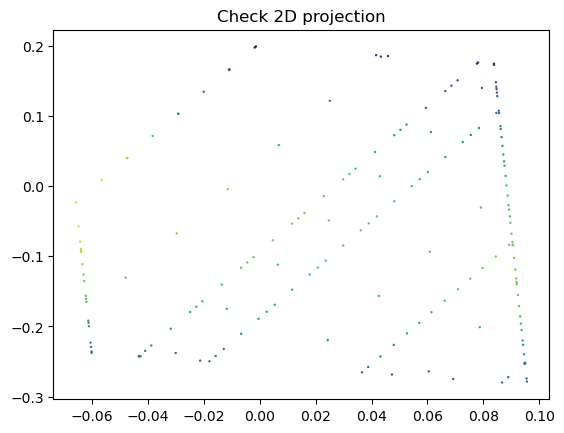

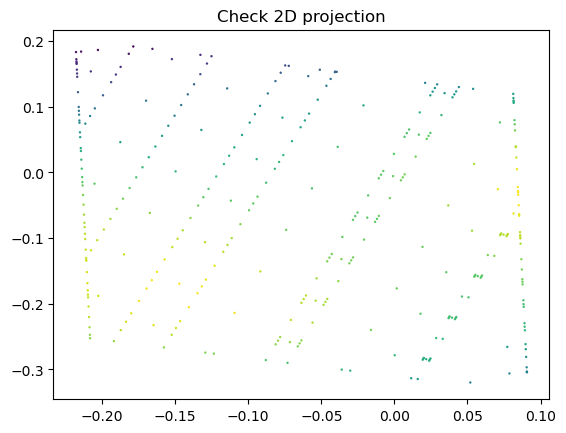

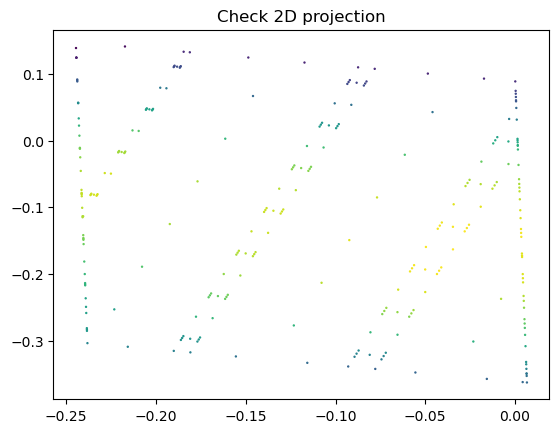

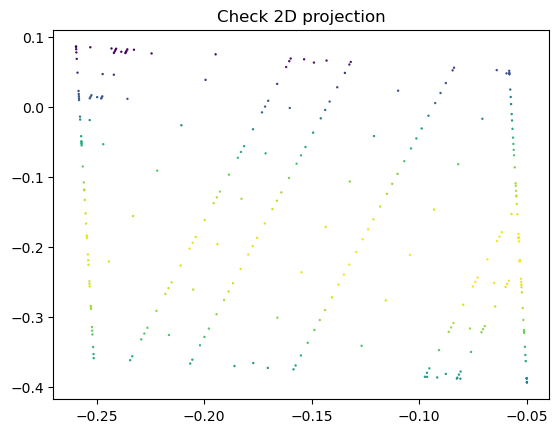

KeyboardInterrupt: 

In [ ]:
append_filter_npr3d = vtk.vtkAppendPolyData()

a = 10*a_

new_point_x = np.array([])
new_point_y = np.array([])
new_point_z = np.array([])
Scalars = np.array([])
step = 4
for i in range(2, 20, step):
    npr3d_ = CutPlane(PlaneClip(ImageVTI, path_points[i],a), path_points[i], binormal[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i-2], direction_points[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i+2], direction_points[i], True)
    append_filter_npr3d.AddInputData(npr3d_)

    x_, y_, z_, scalar_ = RotateStable(npr3d_, direction_points[i], path_normals[i], "Scalars_", path_points[i], New_Centreline[i])
    plt.scatter(z_, x_, c=scalar_, s=0.5)
    plt.title("Check 2D projection")
    plt.show()
    new_point_x = np.concatenate([x_, new_point_x])
    new_point_y = np.concatenate([y_, new_point_y])
    new_point_z = np.concatenate([z_, new_point_z])
    Scalars = np.concatenate([scalar_, Scalars])
    
append_filter_npr3d.Update()
NPR3D = append_filter_npr3d.GetOutput()

opath = os.path.join(InputFolder, "NPR3D.vtp")
WriteVTPFile(opath, NPR3D)

In [36]:
np.array([0,1,0])+np.array([1,0,0])

array([1, 1, 0])

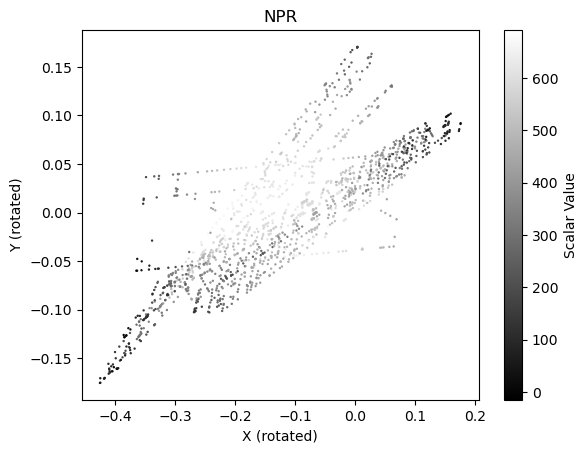

In [38]:
plt.figure()
sc = plt.scatter(new_point_z, new_point_x, c=Scalars, cmap='gray', s=0.5)
plt.colorbar(sc, label='Scalar Value')
#plt.axis('equal')
plt.xlabel('X (rotated)')
plt.ylabel('Y (rotated)')
plt.title('NPR')
plt.show()

Number of centerline points: 113


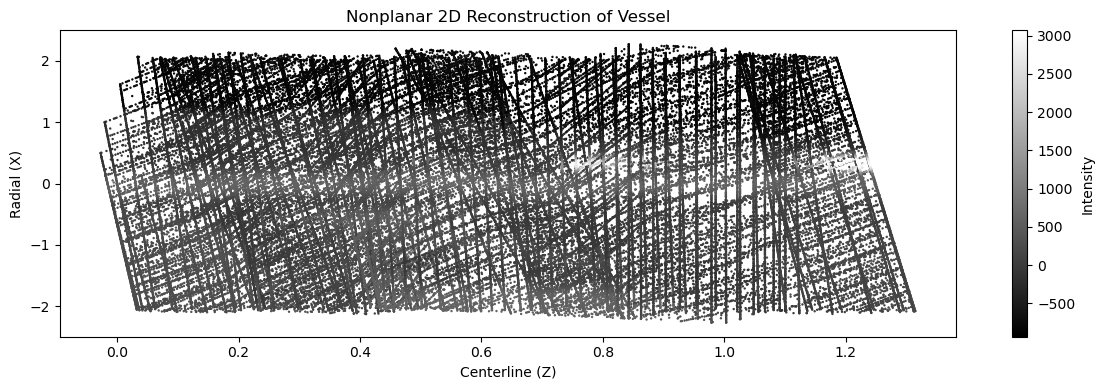

In [47]:
# Clean, stable nonplanar reconstruction with consistent rotation
# You can copy-paste this into your notebook for direct use

import os
import vtk
import numpy as np
import matplotlib.pyplot as plt
from utilities import ReadVTIFile, WriteVTPFile
import xml.etree.ElementTree as ET
from vtk.util.numpy_support import vtk_to_numpy

# Load image
InputFolder = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/FlowVisualization/SU03B/Paths"
g1 = os.path.join(InputFolder, "graft1.pth")
image = os.path.join(InputFolder, "SU03B.vti")
ImageVTI = ReadVTIFile(image)

# CutPlane utility
def CutPlane(Volume, Origin, Norm):
    plane = vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice = vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

# Load path points and directions
with open(g1, "r") as path:
    tree = ET.parse(path)
root = tree.getroot()

direction_points = [
    (float(dp.attrib['x']), float(dp.attrib['y']), float(dp.attrib['z']))
    for dp in root.findall(".//path_point/tangent")
]

path_points = [
    (float(pp.attrib['x']), float(pp.attrib['y']), float(pp.attrib['z']))
    for pp in root.findall(".//path_point/pos")
]

path_normals = [
    (float(r.attrib['x']), float(r.attrib['y']), float(r.attrib['z']))
    for r in root.findall(".//path_point/rotation")
]

NPoints = len(path_points)
print("Number of centerline points:", NPoints)

# Calculate binormal vectors
binormal = []
for i in range(NPoints):
    tangent = np.array(direction_points[i])
    normal = np.array(path_normals[i])
    tangent /= np.linalg.norm(tangent)
    normal /= np.linalg.norm(normal)
    binormal_ = np.cross(tangent, normal)
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)

# Define stable Rotate function
def RotateStable(slice, tangent, normal, ArrayName, centre, new_centre):
    tangent = tangent / np.linalg.norm(tangent)
    normal = normal / np.linalg.norm(normal)
    binormal = np.cross(tangent, normal)
    binormal /= np.linalg.norm(binormal)
    # Form rotation matrix: columns = [binormal, normal, tangent]
    R_mat = np.vstack([binormal, normal, tangent]).T

    new_point_x, new_point_y, new_point_z = [], [], []
    for i in range(slice.GetNumberOfPoints()):
        point = np.array(slice.GetPoint(i))
        point_translated = point - centre
        point_rotated = R_mat @ point_translated
        point_final = point_rotated + new_centre
        new_point_x.append(point_final[0])
        new_point_y.append(point_final[1])
        new_point_z.append(point_final[2])

    scalar_value = vtk_to_numpy(slice.GetPointData().GetArray(ArrayName))
    return np.array(new_point_x), np.array(new_point_y), np.array(new_point_z), scalar_value

# Perform nonplanar reconstruction and visualize
new_point_x, new_point_y, new_point_z, scalars_all = [], [], [], []
a = 2
for i in range(1, NPoints, 2):  # sample every 5th for speed; adjust as needed
    origin = path_points[i]
    norm = path_normals[i]
    #slice = CutPlane(ImageVTI, origin, norm)
    npr3d_ = CutPlane(PlaneClip(ImageVTI, origin, a), origin, norm)
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i-1], direction_points[i])
    slice = clip_polydata_with_plane(npr3d_,path_points[i+1], direction_points[i], True)

    x_, y_, z_, scalar_ = RotateStable(
        slice,
        np.array(direction_points[i]),
        np.array(path_normals[i]),
        "Scalars_",  
        np.array(path_points[i]),
        np.array([0, 0, i * a_/2])  
    )

    new_point_x.append(x_)
    new_point_y.append(y_)
    new_point_z.append(z_)
    scalars_all.append(scalar_)

# Concatenate results
new_point_x = np.concatenate(new_point_x)
new_point_y = np.concatenate(new_point_y)
new_point_z = np.concatenate(new_point_z)
scalars_all = np.concatenate(scalars_all)

# Plot 2D reconstruction using Z (centerline) vs X (radial) plane
plt.figure(figsize=(12, 4))
plt.scatter(new_point_z, new_point_x, c=scalars_all, cmap='gray', s=0.5)
plt.xlabel('Centerline (Z)')
plt.ylabel('Radial (X)')
plt.title('Nonplanar 2D Reconstruction of Vessel')
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()


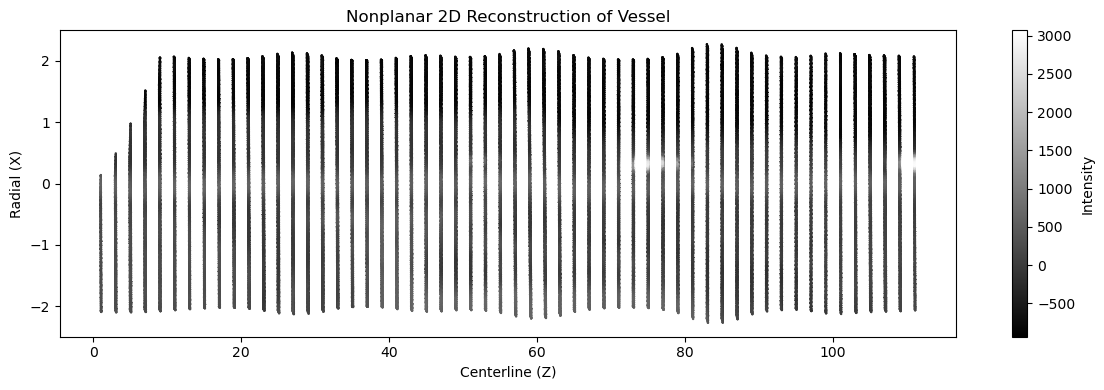

In [46]:
plt.figure(figsize=(12, 4))
plt.scatter(new_point_z, new_point_x, c=scalars_all, cmap='gray', s=0.5)
plt.xlabel('Centerline (Z)')
plt.ylabel('Radial (X)')
plt.title('Nonplanar 2D Reconstruction of Vessel')
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()
